# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Basic Libraries

import pandas as pd
import numpy as np
import IPython.display as ipd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
# Project Specific Libraries

import os
import librosa
import librosa.display
import glob 
import skimage

# Load Data

In [3]:
df = pd.read_csv(r'E:\Speech\archive (6)\UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


# Data Visualization

In [4]:
ipd.Audio(r'E:\Speech\archive (6)\fold5\100032-3-0-0.wav')

In [5]:
ipd.Audio(r'E:\Speech\archive (6)\fold5\100263-2-0-117.wav')

In [6]:
# Sample rate is frequency = number of samples in one second
dat1, sampling_rate1 = librosa.load(r'E:\Speech\archive (6)\fold5\100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load(r'E:\Speech\archive (6)\fold5\100263-2-0-117.wav')

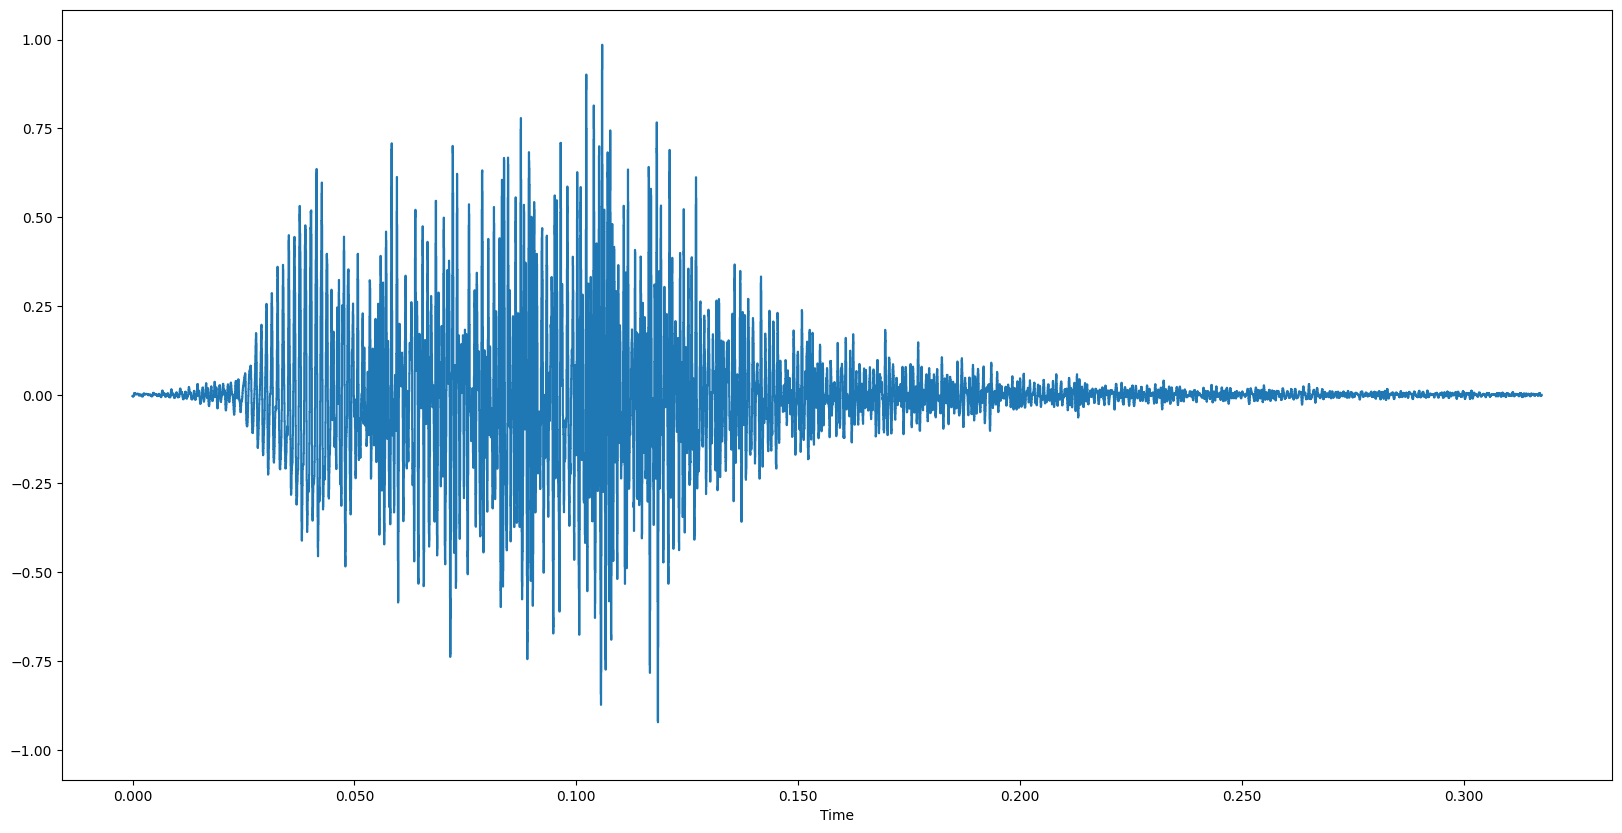

In [7]:
plt.figure(figsize=(20, 10))
librosa.display.waveshow(dat1,sr=sampling_rate1)

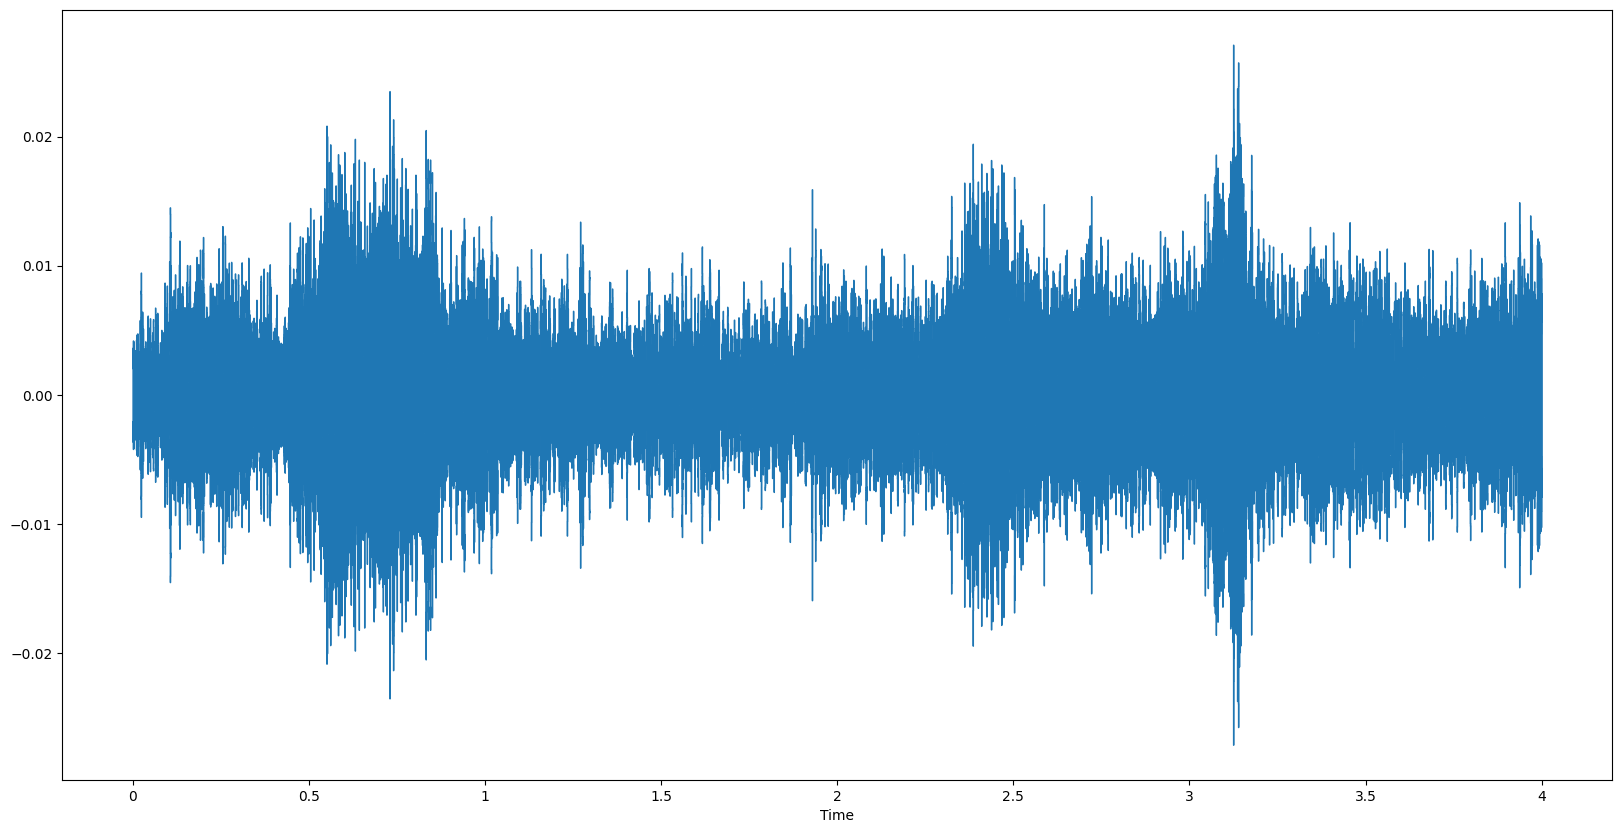

In [8]:
plt.figure(figsize=(20, 10))
librosa.display.waveshow(dat2,sr=sampling_rate2)

In [9]:
df['class']

0               dog_bark
1       children_playing
2       children_playing
3       children_playing
4       children_playing
              ...       
8727            car_horn
8728            car_horn
8729            car_horn
8730            car_horn
8731            car_horn
Name: class, Length: 8732, dtype: object

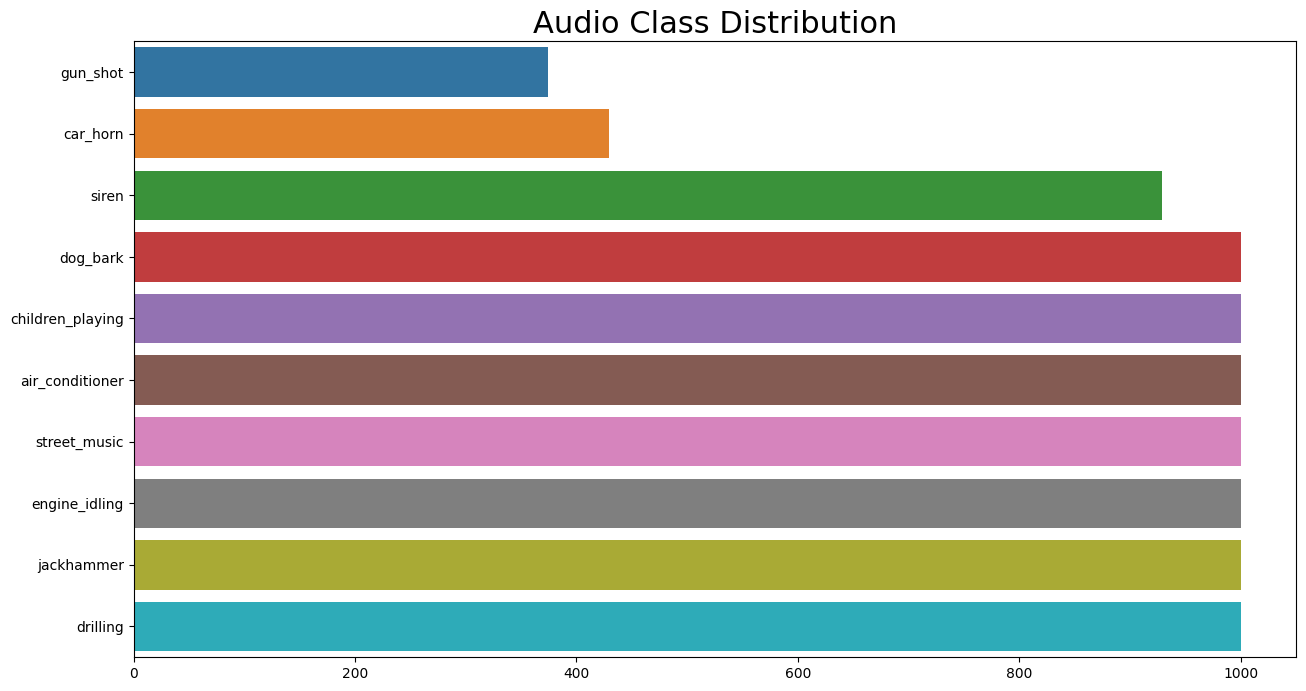

In [10]:
plt.figure(figsize=(15, 8))
plt.title('Audio Class Distribution', fontsize=22)
class_distribution = df['class'].value_counts().sort_values()

sns.barplot(x=class_distribution.values,
            y=list(class_distribution.keys()),
            orient="h"); 

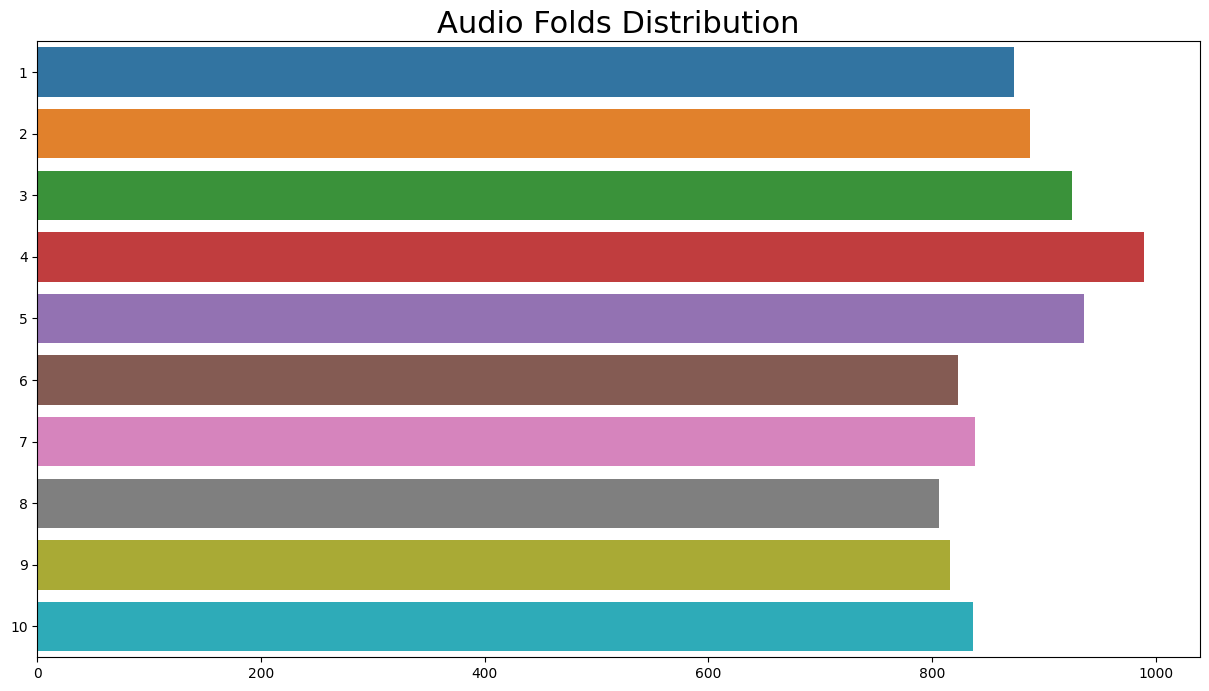

In [11]:
# View Dataset Folds Distribution
plt.figure(figsize=(15, 8))
plt.title('Audio Folds Distribution', fontsize=22)
folds_distribution = df['fold'].value_counts().sort_index()

sns.barplot(x=folds_distribution.values,
            y=list(folds_distribution.keys()),
            orient="h");

# Features Extraction & Preprocessing

In [12]:
def extract_features(data):
    # Zero Crossing Rate
    # the temporal properties of an audio signal 
    #The ZCR is a measure of the number of times the audio signal changes sign per unit time
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))

    # Chroma_stft
    #It is a useful feature for characterizing the tonal properties
    #the chroma feature is a 12-element vector that represents the relative intensity of each of the 12 pitch classes (C, C#, D, D#, E, F, F#, G, G#, A, A#, B)
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate, n_fft=200).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_fft=200).T, axis=0)
    result = np.hstack((result, mfcc))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate, n_fft=200).T, axis=0)
    result = np.hstack((result, mel))

    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0);
    result = np.hstack((result, tonnetz));

    return result

In [13]:
X = []
y = []
up_width = 173
up_height = 40
for i in tqdm(range(8732)):
    file_name = r'E:\Speech\archive (6)\fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
    # Here kaiser_fast is a technique used for faster extraction
    X_, sample_rate = librosa.load(file_name,res_type='kaiser_fast') 
    X_=extract_features(X_)
    X.append(X_)
    y.append(df["classID"][i])

100%|██████████████████████████████████████████████████████████████████████████████| 8732/8732 [23:15<00:00,  6.26it/s]


In [14]:
X=np.array(X)
y=np.array(y)

In [15]:
print(X.shape)
print(y.shape)

(8732, 167)
(8732,)


In [16]:
print(X.shape)

(8732, 167)


In [17]:
print(np.unique(y))

[0 1 2 3 4 5 6 7 8 9]


In [18]:
y = keras.utils.to_categorical(y)

In [19]:
print(np.unique(y))

[0. 1.]


In [20]:
y.shape

(8732, 10)

# Split The Data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.20 )

# Bulid The Model

In [23]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32,kernel_size=3,activation="relu",input_shape=(167,1)),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(64,kernel_size=3,activation="relu"),
    keras.layers.MaxPool1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(512,activation="relu"),
    keras.layers.Dropout(0.7),
    keras.layers.Dense(10,activation="softmax"),
])

In [24]:
print("Model Details :")
print(model.summary())

Model Details :
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 165, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 82, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 80, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 40, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_2 (Dense)             (None, 51

# Train The Model

In [25]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

In [26]:
history=model.fit(X_train,y_train,epochs=200,batch_size=64,verbose=1,validation_data=(X_test,y_test))

Epoch 1/200
110/110 [==============================] - 3s 22ms/step - loss: 3.7280 - accuracy: 0.1827 - val_loss: 1.9644 - val_accuracy: 0.3228
Epoch 2/200
110/110 [==============================] - 2s 21ms/step - loss: 2.0711 - accuracy: 0.2228 - val_loss: 1.8752 - val_accuracy: 0.3492
Epoch 3/200
110/110 [==============================] - 2s 21ms/step - loss: 1.9990 - accuracy: 0.2503 - val_loss: 1.7912 - val_accuracy: 0.3904
Epoch 4/200
110/110 [==============================] - 2s 21ms/step - loss: 1.9068 - accuracy: 0.2965 - val_loss: 1.6969 - val_accuracy: 0.3812
Epoch 5/200
110/110 [==============================] - 3s 23ms/step - loss: 1.8328 - accuracy: 0.3266 - val_loss: 1.5352 - val_accuracy: 0.4957
Epoch 6/200
110/110 [==============================] - 3s 25ms/step - loss: 1.7602 - accuracy: 0.3545 - val_loss: 1.4594 - val_accuracy: 0.5192
Epoch 7/200
110/110 [==============================] - 2s 21ms/step - loss: 1.7102 - accuracy: 0.3818 - val_loss: 1.3883 - val_accuracy:

# Test The Model

In [27]:
loss,acc=model.evaluate(X_test,y_test)

55/55 [==============================] - 0s 2ms/step - loss: 0.6338 - accuracy: 0.9004


# Compare Between Train & Test accurices and losses

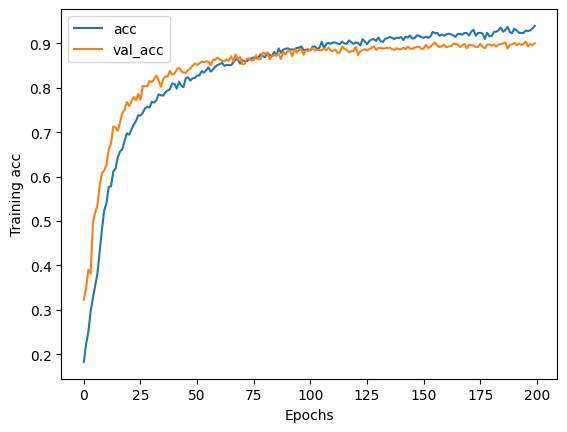

<Figure size 640x480 with 0 Axes>

In [28]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Training acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

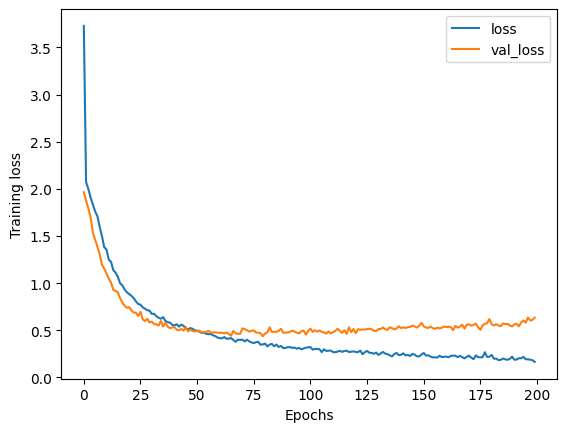

<Figure size 640x480 with 0 Axes>

In [29]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

# Predict Some Data

In [35]:
classes=["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
def print_prediction(file_name):
    audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    pred_fea = extract_features(audio_data)
    pred_fea = np.expand_dims(pred_fea, axis=0)  # Add batch dimension
    pred_fea = np.expand_dims(pred_fea, axis=2)  # Add input dimension
    print(pred_fea.shape)
    pred_vector = np.argmax(model.predict(pred_fea), axis=-1)
    print(pred_vector)
    print("The predicted class is:", classes[pred_vector[0]], '\n')

In [31]:
file_name = r'E:\Speech\archive (6)\fold1\73277-9-0-0.wav'

print_prediction(file_name)

ipd.Audio(file_name)

(1, 167, 1)
1/1 [==============================] - 0s 89ms/step
[9]
The predicted class is: street_music 



In [32]:
file_name = r'E:\Speech\archive (6)\fold1\57320-0-0-0.wav'

print_prediction(file_name)

ipd.Audio(file_name)

(1, 167, 1)
1/1 [==============================] - 0s 16ms/step
[0]
The predicted class is: air_conditioner 



# Save The Model

In [33]:
model.save("Urban Street Sounds Classification.h5")